# Notebook: Basic use of SeismoStats
<div class="alert alert-block alert-info">

This notebook is a manual for the SeismoStats package. It is intended to be used as a reference for the basic functionality. All examples are given using the Swiss national catalog for the year 2024.

 In this notebook we will show how to:
<ol>
    <li> Make a catalog object
    <li>Visualisations</li>
    <ol>
        <li>Spatial plot of the seismicity</li>
        <li>Temporal plot of the seismicity</li>
        <li>Frequency-magnitude distribution plots</li>
    </ol>
    <li>Statistical analysis of the catalog</li>
    <ol>
        <li>Estimation of the magnitude of completeness</li> 
        <li>Estimation of the b-value</li> 
    </ol>
    <li> Advanced statistical analysis</li>
    <ol>
        <li>Stability of b-value over magnitudes of completeness</li>
        <li>Statistical significance of b-value variations</li>
    </ol>
    <li>Generate synthetic catalogs</li>
</ol>

</div>

## 0 Import general packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
import warnings, sys
from pathlib import Path

# configure warning such that file paths are not shown
def showwarning(message, category, filename, lineno, file=None, line=None):
    # Keep only the basename, no directories
    fname = Path(filename).name
    # (Optional) also scrub any home path that might appear inside the message text itself
    text = str(message).replace(str(Path.home()), "~")
    stream = sys.stderr if file is None else file
    stream.write(f"{category.__name__}: {text} ({fname}:{lineno})\n")

warnings.showwarning = showwarning

## 1 Creating a catalog object

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The catalog object is a pandas.DataFrame, where each row represents a single event. A catalog object also comes with  attributes for metadata and methods for visualization and statistical analysis.

The columns typically contain information such as origin time, magnitude, and event location. At a minimum, a Catalog object must include a magnitude column. Common additional data columns include, but are not limited to:
* time (pandas timestamp)
* latitude (float)
* longitude (float)
* depth (float)
* event_type (string)
* mag_type (string)

</font>
</div>

### 1.1 Download a catalog from a web service

In [3]:
from seismostats import FDSNWSEventClient
from seismostats import Catalog

<font color=#208de2> Start date and end date have to be defined as a datetime. In case something does not work out, the link to retrieve it manually is given back. </font>

In [4]:
# Set the time range for the catalog (year 2024)
start_time = pd.to_datetime('2024/01/01')
end_time = pd.to_datetime('2025/01/01')

# Set the geographical bounds for the catalog (Switzerland)
min_longitude = 5
max_longitude = 11
min_latitude = 45
max_latitude = 48

# Set the minimum magnitude for the events to be included in the catalog
min_magnitude = 0.5

# Query the FDSN web service 
url = 'http://eida.ethz.ch/fdsnws/event/1/query'
client = FDSNWSEventClient(url)
cat = client.get_events(
    start_time=start_time,
    end_time=end_time,
    min_magnitude=min_magnitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_latitude=min_latitude,
    max_latitude=max_latitude)

<font color=#208de2> The output is a catalog object</font>

In [5]:
# Show the last few rows of the catalog object
cat.tail()

,event_type,time,latitude,longitude,depth,evaluationmode,magnitude,magnitude_type,magnitude_MLhc
2458,earthquake,2024-01-02 03:54:53.285746,45.869203,6.985509,6000.976562,manual,0.916012,MLhc,0.9160119489
2459,earthquake,2024-01-01 03:50:58.819682,46.854600,10.084163,229.492188,manual,1.411941,MLhc,1.411940589
2460,earthquake,2024-01-01 03:30:28.449568,45.878719,7.022020,6474.609375,manual,0.593754,MLhc,0.5937540993
2461,earthquake,2024-01-01 03:30:28.469196,45.878310,7.022026,6220.703125,manual,0.674713,MLhc,0.674713413
2462,earthquake,2024-01-01 02:39:21.385390,45.865622,6.997327,7802.734375,manual,0.606296,MLhc,0.6062956275


## 2 Seismicity Plots

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The SeismoStats package provides methods to visualize:

<ol>
<li>Seismicity in space</li>
<li>Seismicity in time</li> 
<li>The distribution of magnitudes</li> 
</ol>

</font>
</div>

### 2.1 Spatial visualization of seismicity

#### 2.1.1 Basic spatial plot
By default, the earthquakes in the catalog are a uniform size, and the same color, no map is displayed in the background, no legend is displayed.

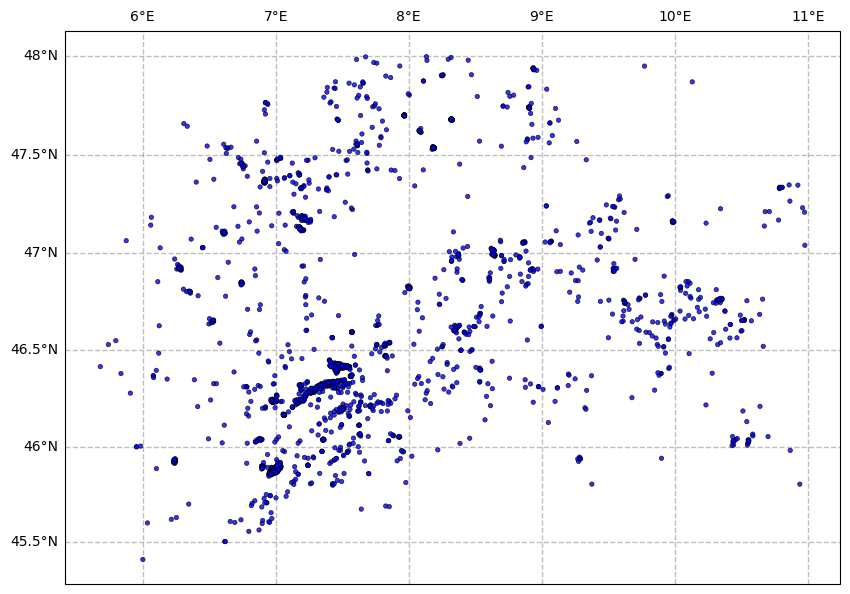

In [6]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    dot_smallest=0.1,
    dot_largest=10,
    dot_interpolation_power=0,
    dot_labels=False)

plt.show()

#### 2.1.2 Adding a background map and scaling events by magnitude
Dots size is limited to a specific range with a scaling factor specified by `dot_interpolation_power`. A legend is added for specified dot sizes (`dot_labels`).

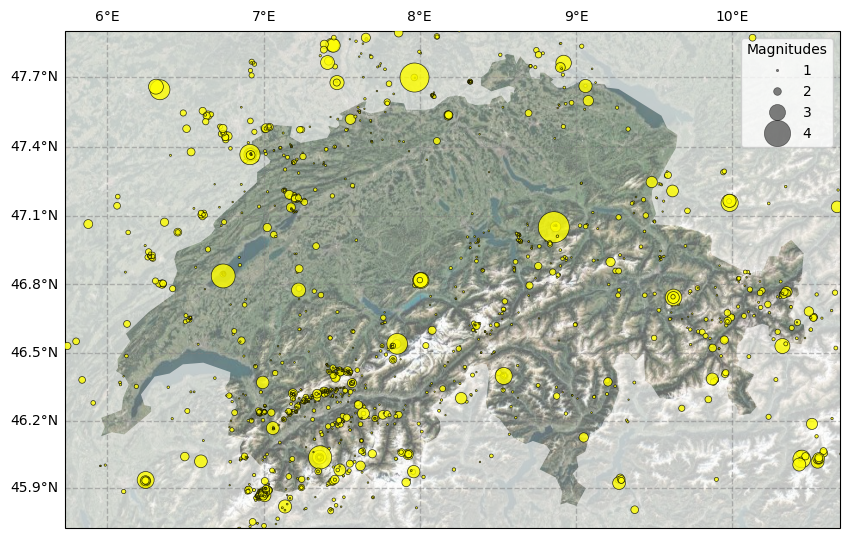

In [7]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    resolution='10m',
    include_map=True, # adds a map in the background
    country='Switzerland', # zooms in on Switzerland and greys out the rest of the map
    dot_smallest=1,
    dot_largest=500,
    dot_interpolation_power=3,
    dot_labels=[1,2,3,4],
    color_dots = 'yellow') # specifies the color of the dots

plt.show()

#### 2.1.3 Temporal coloring of earthquakes
Dots are colored by the time of the event with a color gradient specified in a colorbar (ticks can be specified with `date_ticks`).

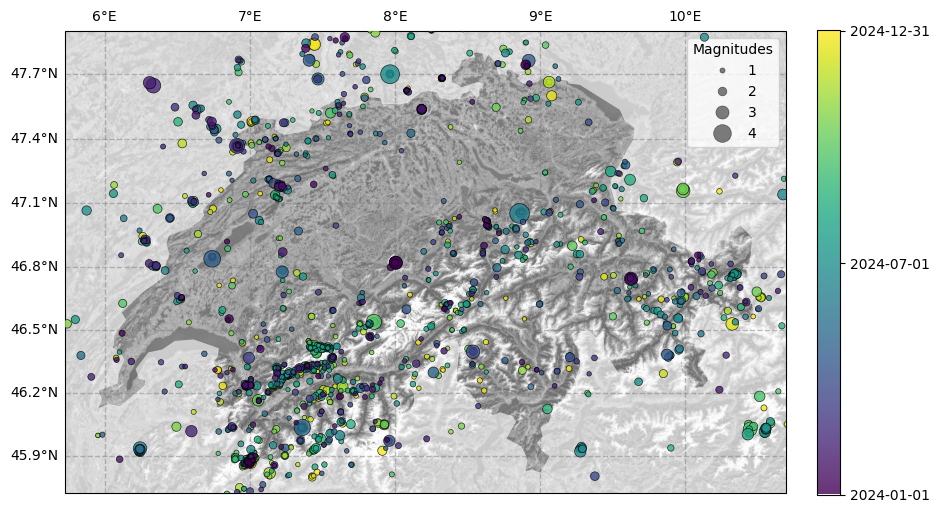

In [8]:
fig = plt.figure(figsize=(10, 10), linewidth=1)

ax = cat.plot_in_space(
    resolution='10m', # resolution of the map, can be '10m', '50m', '110m'
    include_map=True,
    country='Switzerland',
    color_dots=mdates.date2num(cat.time), # color the dots by time (converted to matplotlib date format)
    color_map='Greys_r', # background color for the map (default is terrain color)
    dot_labels=[1, 2, 3, 4] # legend labels for the dots
)

# Add colorbar
cbar = plt.colorbar(ax.collections[1], ax=ax, orientation='vertical', fraction=0.03, pad=0.04)

# Add dates to colorbar
date_ticks = ["2024-01-01", "2024-07-01", "2024-12-31"]
date_ticks_num = mdates.date2num(date_ticks)
cbar.set_ticks(date_ticks_num)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()


### 2.2 Temporal visualization of seismicity 

#### 2.2.1 Cumulative count of events over time
This plot shows the cumulative count of events over time above specific magnitude thresholds. 

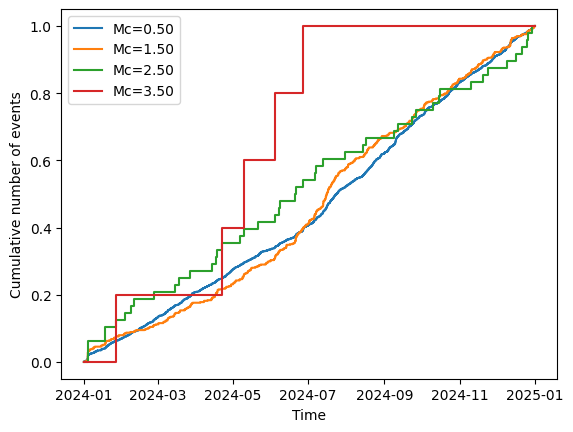

In [9]:
# Define target magnitudes starting at 0.5 and going up to 4.0 in steps of 1.0 magnitude units
target_magnitudes = np.arange(0.5, 4.0, 1.0) 

ax = cat.plot_cum_count(mcs=target_magnitudes)

#### 2.2.2 Timeline of magnitudes 
This plot shows the earthquakes' magnitudes over time. By default the events all have the same color, but you can specify a color gradient based (for example) on the time of the event by specifying `color_dots` as a numpy array.

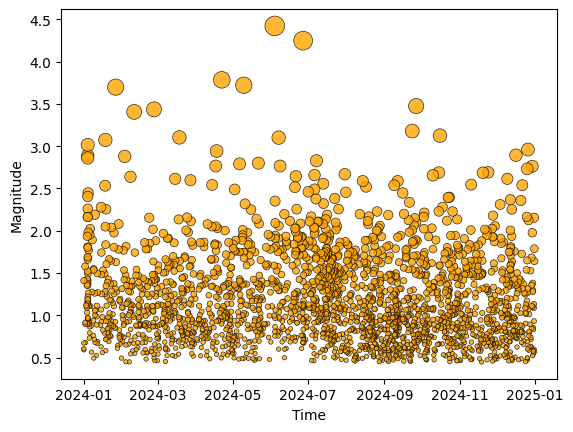

In [10]:
# Basic version without coloring
ax = cat.plot_mags_in_time(color_dots='orange')

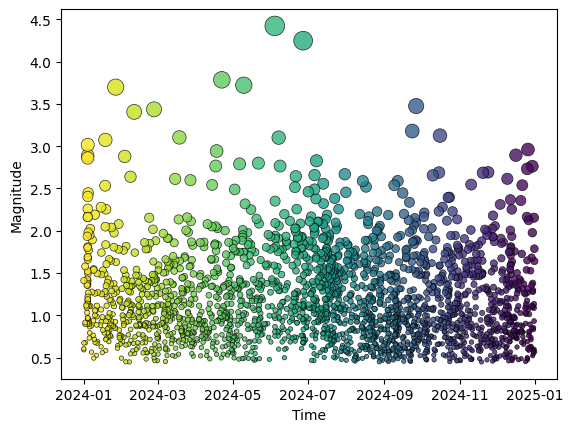

In [11]:
# Coloring events by time
ax = cat.plot_mags_in_time(color_dots=np.arange(len(cat)))

## 3 Frequency-Magnitude Distributions (FMD) and statistical analysis of the catalog
FMD is a histogram-style plot that shows the number of earthquakes per magnitude bin.

### 3.1 Plot the FMD

Legend added to the plot.


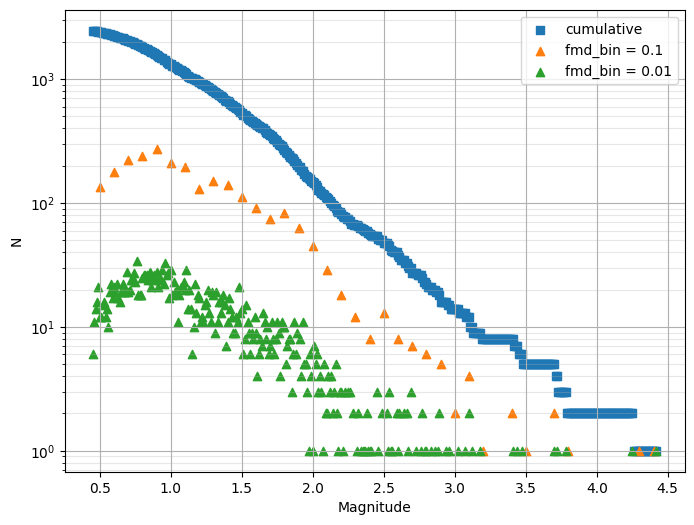

In [12]:
# It is *highly* recommended to bin magnitudes to the catalogue precision before plotting
cat.bin_magnitudes(delta_m=0.01, inplace=True)

# Plot FMD
ax = plt.subplots(figsize=(8, 6))[1]

# cumulative frequency-magnitude distribution
cat.plot_cum_fmd(ax=ax)
# non-cumulative frequency-magnitude distribution with different bin sizes
cat.plot_fmd(fmd_bin=0.1, ax=ax, grid=True, label='fmd_bin = 0.1')
cat.plot_fmd(fmd_bin=0.01, ax=ax, grid=True, label='fmd_bin = 0.01')

plt.show()

### 3.2 Estimate the magnitude of completeness
Currently, SeismoStats supports three methods to estimate the magnitude of completeness:
<ol> 
<li>Maximum Curvature (MAXC)</li>
<li>Mc by b-value stability (MBS)</li>
<li>K-S distance (KS)</li>
</ol>

In [13]:
# Maximum Curvature (MAXC)

# For this method a magnitude discretisation has to be selected by the user with `fmd_bin`. 
# This binning might be different from the binning of the catalog; the optimal value depends on the data. 
mc_maxc, _= cat.estimate_mc_maxc(fmd_bin=0.1)

# By using the a method to estimate the magnitude of completeness, the catalog is automatically updated with the estimated Mc value.
print(f'Estimated Mc using MAXC: {mc_maxc}')
print(f'Mc (currently set catalog attribute): {cat.mc}')

Estimated Mc using MAXC: 1.1
Mc (currently set catalog attribute): 1.1


In [14]:
# Mc by b-value stability (MBS)
mc_stab, _ = cat.estimate_mc_b_stability(stop_when_passed=True)

print(f'Estimated Mc using MBS: {mc_stab}')
# The catalog is automatically updated with the newly estimated Mc value:
print(f'Mc (currently set catalog attribute): {cat.mc}')

return_vals: {'best_b_value': np.float64(1.063578213786541), 'mcs_tested': [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54], 'b_values_tested': [np.float64(0.6147350939454929), np.float64(0.6220316726527602), np.float64(0.6282246925291461), np.float64(0.6337705130377883), np.float64(0.6388937613953332), np.float64(0.642754952015558), np.float64(0.6491173818735427), np.float64(0.6556232891448491),

In [15]:
# K-S distance (KS)
# This method takes longer, especially when the catalog is large. 
# If Mc is known to be larger than a certain value, giving the Mc values that should be tested as an input can make the Mc estimation faster.

mc_kstest, dict = cat.estimate_mc_ks(
   mcs_test=np.arange(1.0, 3.0, 0.1), # range of Mc values to test with steps of 0.1
    p_value_pass=0.1, # p-value threshold to pass the K-S test 
) 

print(f"First Mc to pass the KS test: {mc_kstest:.2f}")
print(f"Associated beta value: {dict['best_b_value']:.2f}")

# The catalog is automatically updated with the newly estimated Mc value:
print(f'Mc (currently set catalog attribute): {cat.mc:.2f}')

First Mc to pass the KS test: 1.60
Associated beta value: 1.10
Mc (currently set catalog attribute): 1.60


Legend added to the plot.


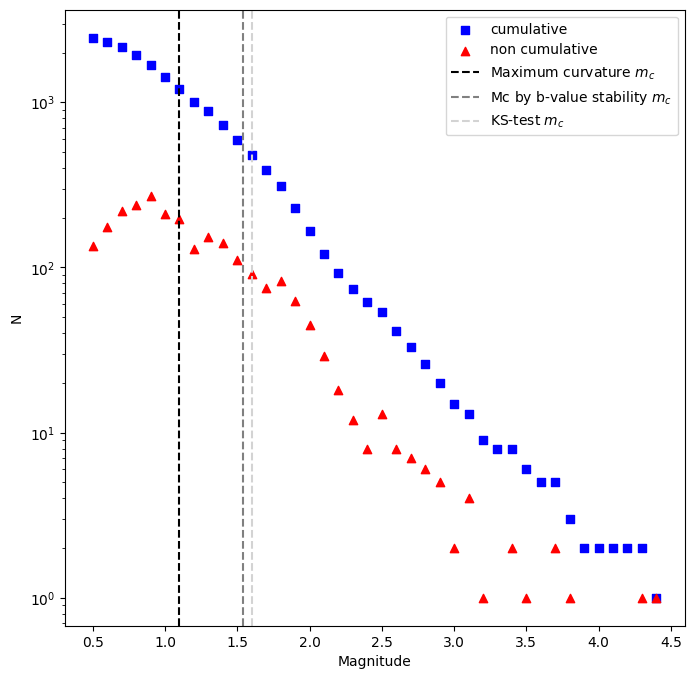

In [16]:
# Plot the FMD with the estimated Mc value
ax = plt.subplots(figsize=(8, 8))[1]

cat.plot_cum_fmd(fmd_bin=0.1, ax=ax, color='blue')
cat.plot_fmd(fmd_bin=0.1, ax=ax, color='red')

plt.axvline(mc_maxc, color='black', linestyle='--', label='Maximum curvature $m_c$')
plt.axvline(mc_stab, color='grey', linestyle='--', label='Mc by b-value stability $m_c$')
plt.axvline(mc_kstest, color='lightgrey', linestyle='--', label='KS-test $m_c$')

plt.legend()
plt.show()

### 3.3 Estimate the b-value
SeismoStats supports different methods to estimate the b-value:
<ol> 
<li>Classical b-value</li>
<li>K-S distance (KS)</li>
<li>Mc by b-value stability (MBS)</li>
</ol>

Note that the Mc set last will be used for the b-value estimation (in this case KS-test).

#### 3.3.1 Classical b-value estimation

In [17]:
b_estimator = cat.estimate_b()

# The calculated b-value is stored in cat.b_value, but the estimator object contains more information:
print('Classical b-value', round(b_estimator.b_value,3))
print('Standard deviation', round(b_estimator.std,2))
print('Number of events used', b_estimator.n)

Classical b-value 1.096
Standard deviation 0.05
Number of events used 434


Legend added to the plot.


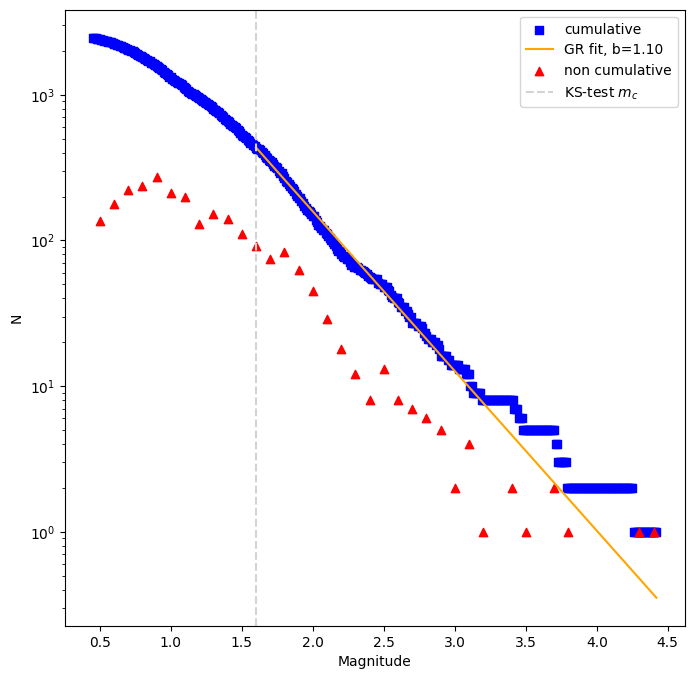

In [18]:
# FMD plot with b-value
# Once a b-value is estimated and stored in cat.b_value, the FMD can be plotted with a fit:
ax = plt.subplots(figsize=(8, 8))[1]
cat.plot_cum_fmd(color='blue',ax=ax, color_line = 'orange')
cat.plot_fmd(fmd_bin=0.1, ax=ax, color='red')

plt.axvline(mc_kstest, color='lightgrey', linestyle='--', label='KS-test $m_c$')
plt.legend()
plt.show()

#### 3.3.2 b-positive

In [19]:
from seismostats.analysis import BPositiveBValueEstimator
b_estimator = cat.estimate_b(method =BPositiveBValueEstimator)
print("b-positive:",round(cat.b_value,2))

b-positive: 1.13


## 4 Advanced statistical analysis of the catalogue

### 4.1 b-value stability

<Axes: xlabel='Completeness magnitude $m_c$', ylabel='b-value'>

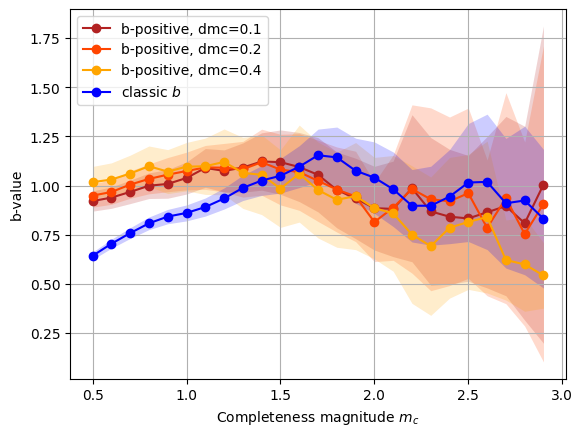

In [20]:
# b-value for different mangitudes of completeness
from seismostats.analysis import ClassicBValueEstimator, BPositiveBValueEstimator

mcs = np.arange(0.5, 3, 0.1)
ax = cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.1, color='firebrick', label='b-positive, dmc=0.1')
cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.2, ax=ax,  color='orangered', label='b-positive, dmc=0.2')
cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.4, ax=ax,  color='orange', label='b-positive, dmc=0.4')

cat.plot_mc_vs_b(mcs, b_method=ClassicBValueEstimator, ax =ax, color='blue', label='classic $b$')

#### 4.2 Timeseries of b-values
Plotting the evolution of b-values (classic and positive) over time can help identify changes in seismicity patterns. One can also investigate if the variation of the b-value is larger than what one would expect just from random fluctuation of the estimate and reject a null-hypothesis of b-value being constant over time using the mean autocorrelation (see Mirwald et al., 2024).

Text(0.5, 0, 'Time')

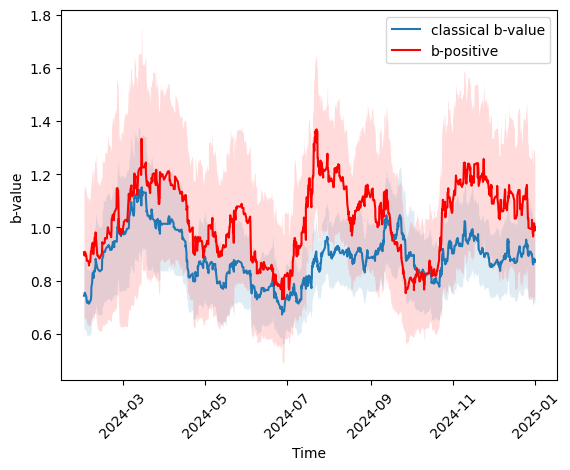

In [21]:
from seismostats.analysis import b_significant_1D
from seismostats.plots import plot_b_series_constant_nm, plot_b_significant_1D

# Parameter setting for the b-value series
mc = 1 # chosen magnitude of completeness
delta_m = cat.delta_m # binning of the magnitudes
times = cat.time 
mags = cat.magnitude
n_m = 100 # number of magnitudes taken per estimate in the running window (above completeness)

ax = plot_b_series_constant_nm(mags, delta_m, mc, times, n_m=n_m, x_variable=times, color='#1f77b4', plot_technique='right', label='classical b-value')

ax = plot_b_series_constant_nm(mags, delta_m, mc, times, n_m=n_m, x_variable=times, color='red', plot_technique='right', label='b-positive', ax=ax, method=BPositiveBValueEstimator)

_ = plt.xticks(rotation=45)
ax.set_xlabel('Time')

In [22]:
# Is the b-value calculated with 100 events above completeness constant over time?
p_threshold = 0.05
p, mac, mu_mac, std_mac = b_significant_1D(mags, mc, delta_m, times, n_m, x_variable=times, method= BPositiveBValueEstimator)
print('The p-value of a constant b-value hypothesis is {:.2f}'.format(p))

print('This is significantly larger than our threshold of {:.2f}. Therefore, we cannot reject the null-hypothesis'.format(p_threshold))


The p-value of a constant b-value hypothesis is 0.42
This is significantly larger than our threshold of 0.05. Therefore, we cannot reject the null-hypothesis


<Axes: xlabel='$n_m$', ylabel='MAC'>

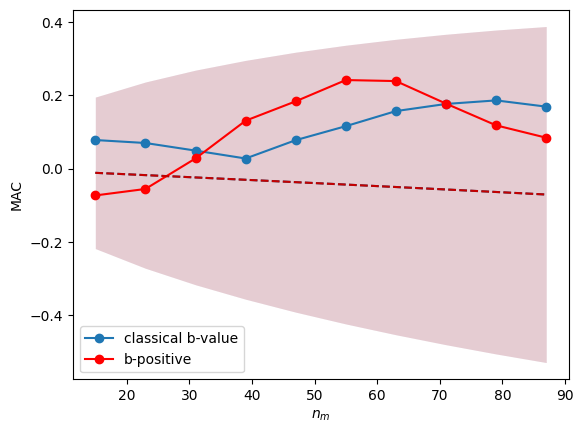

In [23]:
# sort magnitudes along dimension of interest (in this case, time)
srt = np.argsort(times)
mags = mags[srt]
times = times[srt]

ax = plot_b_significant_1D(
    mags, mc, delta_m, times, x_variable=times, color = '#1f77b4', label='classical b-value')

plot_b_significant_1D(
    mags, mc, delta_m,  times, x_variable=times, method=BPositiveBValueEstimator, color = 'red', ax = ax, label='b-positive')


## 5 Support functions

### 5.1 Synthetic catalog generation

In [24]:
from seismostats.utils import simulate_magnitudes_binned

# Parameter setting for the synthetic catalog
n = 500 # number of events to simulate
b_value = 1.5 # b-value of the synthetic catalog
delta_m = 0.05 # magnitude binning of the synthetic catalog
mc = 3 # completeness of the synthetic catalog
dmc = 0.3 

# Generate synthetic magnitudes
mags = simulate_magnitudes_binned(n, b_value, mc, delta_m)
cat = pd.DataFrame({'magnitude': mags})
cat = Catalog(cat)
cat.delta_m = delta_m
cat.mc = mc

# Analyse the synthetic catalog
cat.estimate_b()
print('Estimated b-value of the synthetic catalog:', round(cat.b_value,2))

Estimated b-value of the synthetic catalog: 1.52


Legend added to the plot.


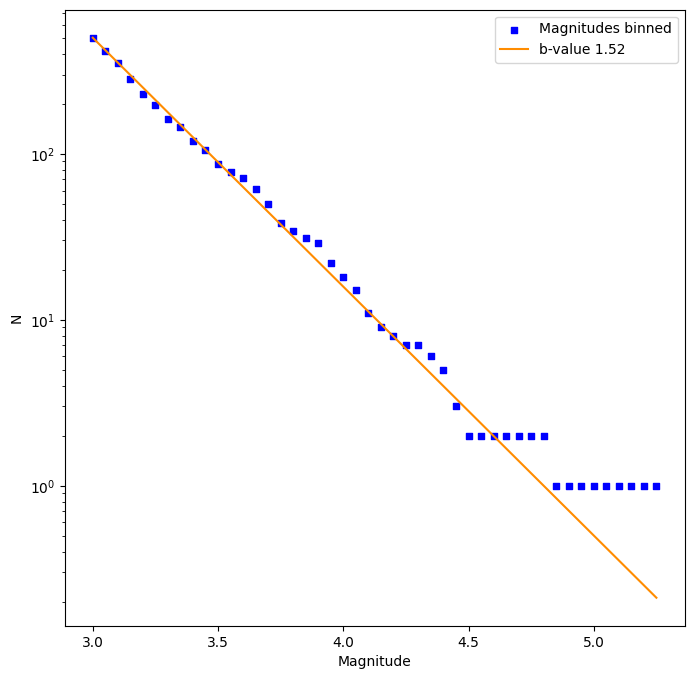

In [25]:
# Plot the synthetic catalog
ax = plt.subplots(figsize=(8, 8))[1]

cat.plot_cum_fmd(ax=ax, b_value=b_value,
             color='blue', color_line = 'darkorange', label='Magnitudes binned', label_line = f'b-value {cat.b_value:.2f}', size=20)

plt.show()

It is also possible to generate magnitudes with varying completeness level

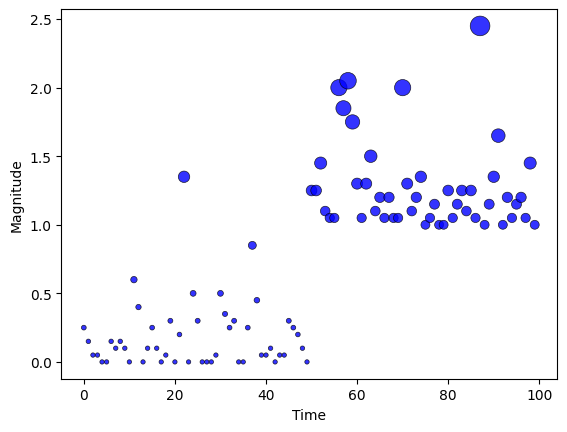

In [26]:
from seismostats.utils import simulate_magnitudes_binned
from seismostats.plots import plot_mags_in_time
n = 100         # number of events to simulate
b_value = 1.5   # b-value of the synthetic catalog
delta_m = 0.05  # magnitude binning of the synthetic catalog
mc = np.zeros(n)          # completeness of the synthetic catalog
mc[n//2:] = 1
mags = simulate_magnitudes_binned(n, b_value, mc, delta_m)
ax = plot_mags_in_time(np.arange(len(mags)), mags)